In [5]:
# !git clone https://github.com/parth1620/Project-NST.git

Cloning into 'Project-NST'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 19 (delta 2), reused 1 (delta 1), pack-reused 16
Receiving objects: 100% (19/19), 3.30 MiB | 373.00 KiB/s, done.
Resolving deltas: 100% (2/2), done.


In [1]:
# loading the vgg pretrained model
import torch
from torchvision.models import vgg19, VGG19_Weights

vgg= vgg19(weights=VGG19_Weights.DEFAULT)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

- **Feature:** consider(convolution, activation, pooling).
- **Classifier:** Do not consider(fullyt connected ie linear, and activation layer).
- In **Neural style transfer** we do not want a classifier as we want to extract the content image features and style  image features.

In [2]:
#lets remove the vgg classifier or we can just take the features
vgg= vgg.features
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

- Now we know as we want the feature so there is no need for computation ie finding the gradient, so we will false the gradient in furthur step and use the default weight ie **freeze** the model.

In [3]:
#freeze the model ie freeze all the layers so no weights
# and biases updation will occur. ie no training in the furthur steps.
for param in vgg.parameters():
    param.requires_grad= False

In [4]:
# import torch
# torch.cuda.is_available()

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    vgg = vgg.to(device) #converting our model to gpu
    print("Tensor moved to GPU")
else:
    print("GPU is not available, using CPU instead")

Tensor moved to GPU


In [6]:
# torch.cuda.device_count()
# torch.cuda.current_device()

# Preprocess image

In [7]:
from PIL import Image
from torchvision import transforms as T

In [8]:
def preprocess(img_path, img_max_size= 500):
    image= Image.open(img_path).convert('RGB')
#     print('before transform')
#     print(image.size)
    if max(image.size)>img_max_size:
        size= img_max_size
    else:
        size= max(image.size)
    print('size: ', size)
    img_transforms= T.Compose([
        T.Resize(size), 
        T.ToTensor(),
        T.Normalize(mean= [0.485, 0.456, 0.406],
                   std= [0.229, 0.224, 0.225])
    ])
    image= img_transforms(image)
#to know how resizing occur see doc https://pytorch.org/vision/main/generated/torchvision.transforms.functional.resize.html
#     print('after transform')
#     print(image.shape)
    image= torch.unsqueeze(image, 0)# (3c,244h,244w)->(1b(imageno.),3c,244h,244w)
    return image

In [9]:
# content image and style image
content_image_preprocess= preprocess('./Project-NST/content11.jpg')
style_image_preprocess= preprocess('./Project-NST/style12.jpg')

content_input_img= content_image_preprocess.to(device)
style_input_img= style_image_preprocess.to(device)

#lets see the size of images
print(f'content_image_preprocess size: {content_image_preprocess.shape}\
\t style_image_preprocess size: {style_image_preprocess.shape}')

size:  259
size:  500
content_image_preprocess size: torch.Size([1, 3, 259, 345])	 style_image_preprocess size: torch.Size([1, 3, 625, 500])


In [10]:
# from PIL import Image
# image= Image.open('./Project-NST/style12.jpg')
# image.show()

# Deprocess Image
- The reason we deprocessing the image is beacuse the plotting lib does not support gpu tensor so, we convert into cpu tensor shape, tensor returns shape is (c,h,w) but to display image we need (h,w,c) (for this u can use permute() function), we need to squeeze it because plot function does not take batch to remove unsqueeze tensor we did in preprocess we are doing this, transpose the axis (c,h,w)->(h,w,c), denormalize it as we want to get rgb back.

In [23]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
def depreprocess(tensor):
    image= tensor.to('cpu').clone()
    #converting to numpy
    image= image.numpy()
    #squeezing the tensor
    image= image.squeeze(0)#ex: (1,3,224,224)->(3,224,224)
    #tranpose
    image= image.transpose(1,2,0)#(3,224,224)->(224,224,3)
    #denormalise
    image= image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]) #image = ((image * std) + mean) refer this https://discuss.pytorch.org/t/understanding-transform-normalize/21730
    #clip the image between 0 and 1
    image= image.clip(0,1)#to remove the blurness 
    
    return image

In [25]:
# content image and style image
content_image_depreprocess= depreprocess(content_input_img)
style_image_depreprocess= depreprocess(style_input_img)

#lets see the size of images
print(f'content_image_depreprocess size: {content_image_depreprocess.shape}')
print(f'style_image_depreprocess size: {style_image_depreprocess.shape}')

content_image_depreprocess size: (259, 345, 3)
style_image_depreprocess size: (625, 500, 3)


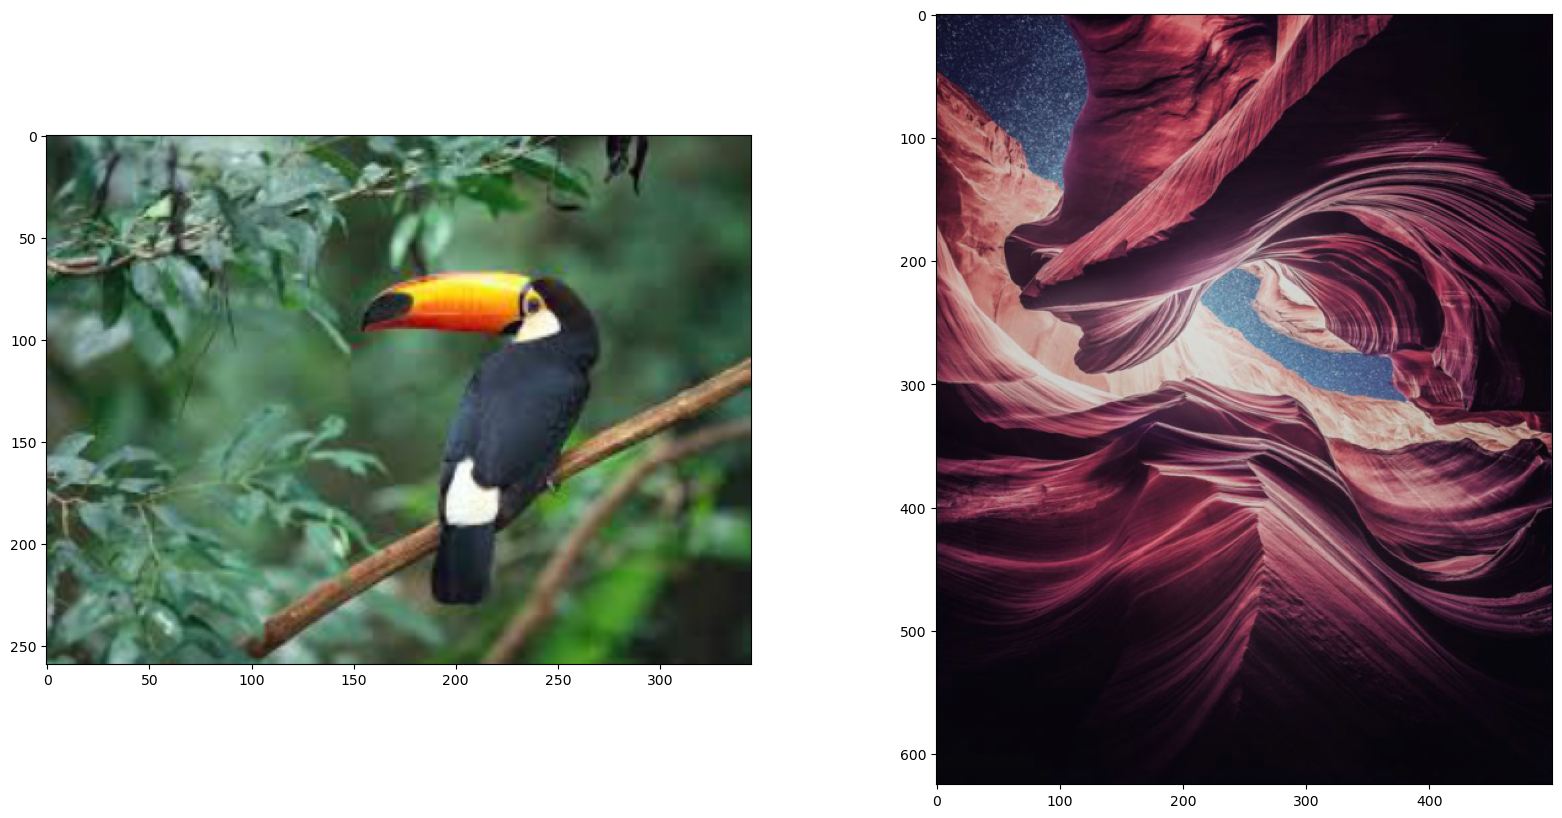

In [26]:
#lest plot the images
fig, (ax1,ax2)= plt.subplots(1,2, figsize=(20,10))
ax1.imshow(content_image_depreprocess)
ax2.imshow(style_image_depreprocess)


# Get content, style features and create gram matrix

In [10]:
def getFeatures(image, model):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    layers= {
        '0': 'conv1_1',
        '5':'conv2_1',
        '10':'conv3_1',
        '19':'conv4_1',
        '21':'conv4_2',#content features
        '28':'conv5_1'
    }
    x= image
    features={}
    for name, layer in model._modules.items():
        x= layer(x)
        if name in layers:
            features[layers[name]]= x
    
    return features

In [11]:
content_f= getFeatures(content_input_img, vgg)
style_f= getFeatures(style_input_img, vgg)

In [12]:
style_f

{'conv1_1': tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[1.9450, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [4.7017, 0.3099, 0.1908,  ..., 0.2384, 0.1023, 0.0000],
           [5.0920, 1.1697, 0.7236,  ..., 0.3344, 0.1895, 0.0000],
           ...,
           [5.3973, 0.2957, 0.2957,  ..., 0.2614, 0.2614, 0.0000],
           [5.3973, 0.2957, 0.2957,  ..., 0.2766, 0.2766, 0.0000],
           [6.8957, 4.0818, 4.0818,  ..., 4.1078, 4.1078, 0.0595]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0

# gram matrix
- **what is gram matrix?**  
    - The measure by which we capture the distribution of features over a set of feature maps in a given layer
    - style information is measured as the amount of correlation present between the feature maps per
    - Gram matrix is the measure by which we capture the distribution of features over a set of feature maps in a given layer.
    - **gram matrix = matrix/image * transpose matrix/image**
- **why to use gram matrix**
    - The reason is we know during modeling each layer extract features and each layer has different features which are independent of each other. so finding style from those is not possible so there comes the gram matrix which find the correlation between layer.
    - refer this https://youtu.be/Elxnzxk-AUk
- **How to find the gram matrix**
    - (convert feature map into vector) * (transpose of convert feature map into vector)

In [13]:
def gram_matrix(tensor):
    b, c, h, w= tensor.size()
    tensor = tensor.view(c, h*w)
    gram= torch.mm(tensor, tensor.t())
    return gram

In [14]:
style_gram = {layer : gram_matrix(style_f[layer]) for layer in style_f}

# content loss and style loss

In [15]:
def content_loss(target_conv4_2, contentconv4_2):
    loss= torch.mean(target_conv4_2 - contentconv4_2)**2
    return loss

In [16]:
style_weights= {
    'conv1_1': 1.0,
    'conv2_1': 0.75,
    'conv3_1': 0.2,
    'conv4_1': 0.2,
    'conv5_1': 0.2
}

In [17]:
def style_loss(style_weights, target_features, style_grams):
    loss= 0
    
    for layer in style_weights:
        target_f= target_features[layer]
        target_gram= gram_matrix(target_f)
        style_gram= style_grams[layer]
        b,c,h,w= target_f.shape
        layer_loss= style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        loss+= layer_loss/(c*h*w)
        
    return loss

In [18]:
target =  content_input_img.clone().requires_grad_(True).to(device)
target_f = getFeatures(target,vgg)
print('content loss : ', content_loss(target_f['conv4_2'], content_f['conv4_2']))
print('style loss : ', style_loss(style_weights, target_f, style_gram))

content loss :  tensor(0., device='cuda:0', grad_fn=<PowBackward0>)
style loss :  tensor(1790.8411, device='cuda:0', grad_fn=<AddBackward0>)


In [19]:
 content_input_img

tensor([[[[-1.3302, -1.3644, -1.3987,  ..., -1.2617, -1.2617, -1.2617],
          [-1.3473, -1.3815, -1.4158,  ..., -1.2617, -1.2617, -1.2617],
          [-1.3644, -1.3987, -1.4158,  ..., -1.2617, -1.2617, -1.2617],
          ...,
          [-1.3815, -1.3815, -1.4329,  ..., -1.7240, -1.7240, -1.7240],
          [-1.1418, -1.1075, -1.1589,  ..., -1.6727, -1.6727, -1.6727],
          [-0.5767, -0.5767, -0.6623,  ..., -1.6727, -1.6727, -1.6727]],

         [[-0.8803, -0.9153, -0.9678,  ..., -0.9153, -0.9153, -0.9153],
          [-0.8978, -0.9328, -0.9853,  ..., -0.9153, -0.9153, -0.9153],
          [-0.9153, -0.9503, -0.9853,  ..., -0.9153, -0.9153, -0.9153],
          ...,
          [-0.6352, -0.6527, -0.7052,  ..., -1.4580, -1.4580, -1.4580],
          [-0.1800, -0.1625, -0.2150,  ..., -1.4930, -1.4930, -1.4930],
          [ 0.3978,  0.3803,  0.2927,  ..., -1.4930, -1.4930, -1.4930]],

         [[-0.8633, -0.8981, -0.9504,  ..., -0.9853, -0.9853, -0.9853],
          [-0.8807, -0.9156, -

# Training loop

In [20]:
from torch import optim

In [21]:
# usually we used to pass MODEL PARAMETER ie the weights and biases for updatioin but here
# w are using it to update the pixel value of the target when the loss gets mininmize
optimizer = optim.Adam([target], lr=0.003)
#hyperparametrs initialize
alpha = 1
beta = 1e5

epochs = 3000

show_every = 500

In [28]:
def total_loss(cl, st, alpha, beta):
    loss= alpha*cl + beta*sl
    return loss

In [29]:
results = []
for i in range(epochs):
    target_f = getFeatures(target, vgg)
    cl= content_loss(target_f['conv4_2'], content_f['conv4_2'])
    sl= style_loss(style_weights, target_f, style_gram)
    tl = total_loss(cl,sl, alpha,beta)
    
    optimizer.zero_grad()
    tl.backward()
    optimizer.step()
    
    if i%show_every==0:
        print(f"Total loss at Epoch {i}: {tl}")
        results.append(depreprocess(target.detach()))

Total loss at Epoch 0: 179084112.0
Total loss at Epoch 500: 27116092.0
Total loss at Epoch 1000: 15145012.0
Total loss at Epoch 1500: 11684039.0
Total loss at Epoch 2000: 9622657.0
Total loss at Epoch 2500: 8212876.5


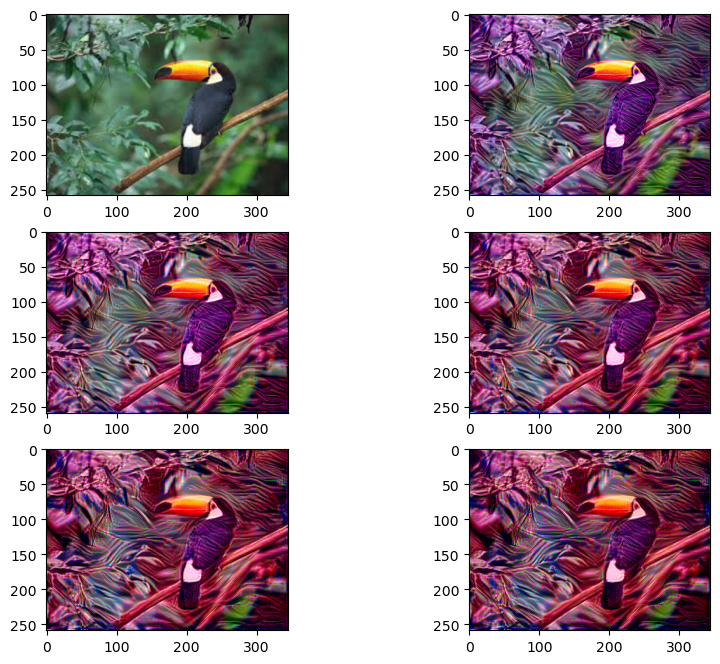

In [31]:
plt.figure(figsize= (10,8))
for  i in range(len(results)):
    plt.subplot(3,2, i+1)
    plt.imshow(results[i])
plt.show()

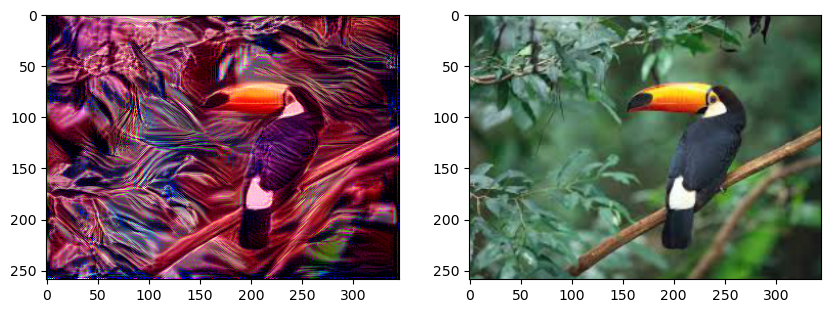

In [32]:
target_copy = depreprocess(target.detach())
content_copy = depreprocess(content_input_img)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.imshow(target_copy)
ax2.imshow(content_copy)